In [62]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from torchvision.ops.misc import interpolate
from tqdm.notebook import tqdm

#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *
from scipy.spatial import procrustes as scipro


importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [96]:
dataset = 'ecoLennyTest'
models  = ['saycam', 'ego']
#models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 768)

In [97]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

In [98]:
### check if images were shown in the same order
assert imagelists[models[0]] == imagelists[models[1]]
imagelist = imagelists[models[0]] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate

nb_per_cat

50

In [99]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])

In [100]:
compactness, compact_categories = max_rsa.compute_compactness(cat_activations, models, listcat, measure = 'Fisher_discriminant')

saycam
ego


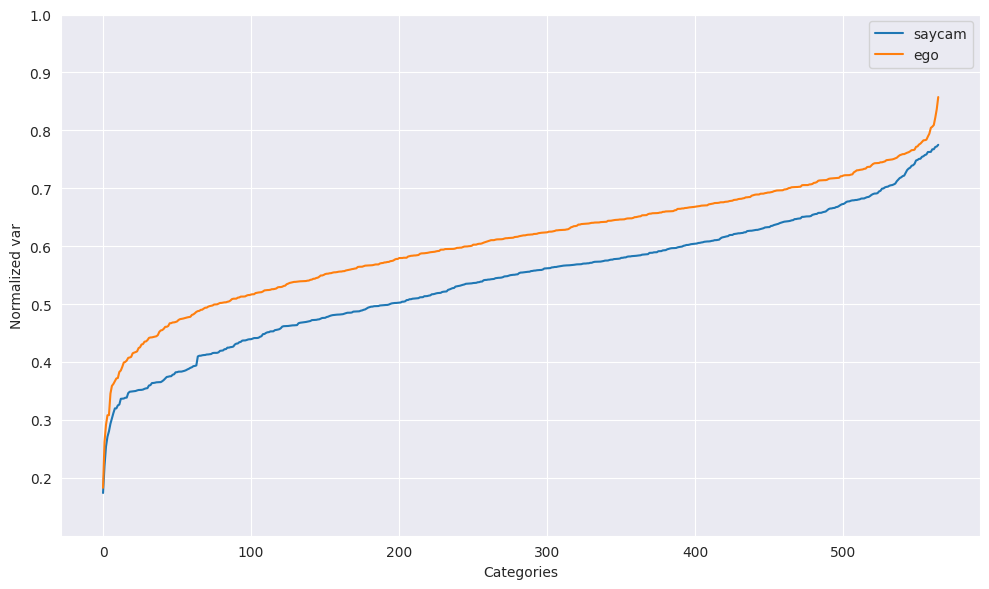

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Categories', ylabel='Normalized var'>)

In [101]:
max_rsa.plot_stats_one(compactness,models,  ['Categories', 'Normalized var'])

In [106]:
RDMs = {}
metric = 'L2squared'
for i, model in enumerate(models):
    print(model)
    RDMs[model] = rsa.compute_RDMs(activations[model], metric = metric, display = False, title = f'{model}_{metric}')

saycam
ego


In [ ]:
mean_RDM = {}
for i, model in enumerate(models):
    mean_RDM[model] = np.zeros(len(listcat), len(listcat))
    for c, cat in enumerate(listcat):
        mean_RDM[model][:,c] = np.mean(RDMs[model][:, nb_per_cat], axis = 0)

In [102]:
submodels = ['saycam', 'ego']
nb_categories = len(listcat)
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(
                compact_categories, compactness, nb_categories, listcat, models = submodels,
                nb_considered_categories = 12, compactness_diff_measure = 'normalizedDiff'
            )

12
The 12 categories leading to the max differences between saycam and ego are ['1548_matchbook' '1787_koala' '2002_wand' '2396_bison' '1176_library'
 '0339_bread' '2720_artichoke' '2758_cube' '1096_onion' '2089_sundial'
 '0215_axe' '2777_stapler']
Category numbers are [423 460 485 525 349 129 548 550 327 489  80 551]
With differences in compactness of  [-0.6020968  -0.5693908  -0.51643795 -0.5100295  -0.5070225  -0.49124607
 -0.46743688 -0.4623981  -0.45281947 -0.45127103  0.44808882 -0.44296548]


In [52]:
def find_subsimilar_subset(cat_activations, submodels, categories,  images_per_subset = 4, nb_per_category = 50):
    nb_categories = len(categories)
    dissimilarity_metric = 'L2squared'
    #### First build the RDMs using all images of the chosen categories to get the general stats
    cat_activations_subset1 = cat_activations[submodels[0]][categories]
    cat_activations_subset2 = cat_activations[submodels[1]][categories]

    cat_shape = cat_activations_subset1.shape

    RDM1 = rsa.compute_RDMs(cat_activations_subset1.reshape(cat_shape[0]*cat_shape[1], -1), metric = dissimilarity_metric, display = False)
    RDM2 = rsa.compute_RDMs(cat_activations_subset2.reshape(cat_shape[0] * cat_shape[1], -1),
                            metric=dissimilarity_metric, display=False)
    RDM1_centered = RDM1 - np.mean(RDM1)
    RDM2_centered = RDM2 - np.mean(RDM2)

    RDM1_norm = RDM1_centered / np.sqrt(np.sum(RDM1_centered**2, axis=0))
    RDM2_norm = RDM2_centered / np.sqrt(np.sum(RDM2_centered**2, axis=0))

    correlations = np.sum(RDM1_norm*RDM2_norm, axis=0)
    category_correlations = correlations.reshape(nb_categories, -1)

    # Initialize arrays for sorted results
    correlations_sorted = np.zeros(len(RDM1))
    sort_indices = list()
    category_boundaries = []

    # Sort within each category (12 categories, 50 images each)
    for cat in range(nb_categories):
        start_idx = cat * nb_per_category
        end_idx = (cat + 1) * nb_per_category

        # Get correlations for this category
        cat_correlations = correlations[start_idx:end_idx]

        # Get sorting indices (lowest to highest correlation)
        cat_sort_indices = np.argsort(cat_correlations)

        # Store sorted correlations
        correlations_sorted[start_idx:end_idx] = cat_correlations[cat_sort_indices]

        # Store original indices (adjusted for global position)
        sort_indices.append(start_idx + cat_sort_indices[:images_per_subset])

        # Store category boundaries
        category_boundaries.append((start_idx, end_idx))

    sort_indices = np.array(sort_indices).flatten()
    # Reorder RDM columns according to the sorting
    RDM1_sorted = RDM1[np.ix_(sort_indices, sort_indices)]
    RDM2_sorted = RDM2[np.ix_(sort_indices,sort_indices)]

    return RDM1, RDM2, RDM1_sorted, RDM2_sorted

In [104]:
RDM1, RDM2, RDM1_sorted, RDM2_sorted = max_rsa.find_subsimilar_subset(cat_activations, submodels, labels[:12],  images_per_subset = 4, nb_per_category = 50)

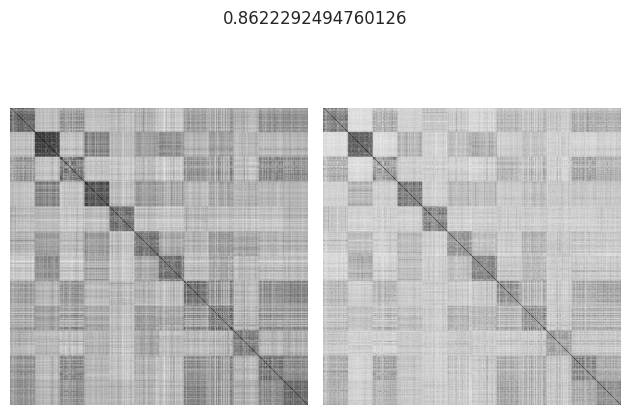

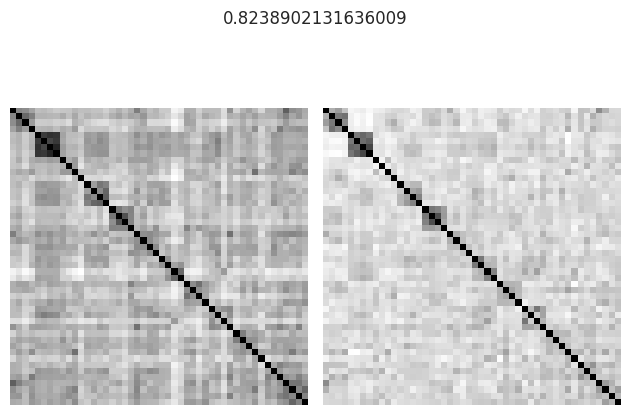

In [105]:
fig, subs = plt.subplots(1,2, sharex=True, sharey=True)
subs[0].imshow(RDM1, cmap='gray')
subs[1].imshow(RDM2, cmap='gray')
subs[0].axis('off')
subs[1].axis('off')
fig.suptitle(f'{np.corrcoef(RDM1.flatten(), RDM2.flatten())[0, 1]}')
fig.tight_layout()

fig, subs = plt.subplots(1,2, sharex=True, sharey=True)
subs[0].imshow(RDM1_sorted, cmap='gray')
subs[1].imshow(RDM2_sorted, cmap='gray')
subs[0].axis('off')
subs[1].axis('off')
fig.suptitle(f'{np.corrcoef(RDM1_sorted.flatten(), RDM2_sorted.flatten())[0, 1]}')
fig.tight_layout()

In [ ]:
from itertools import combinations
categories = labels[:12]
dissimilarity_metric = 'L2squared'
images_per_subset = 4

#### First build the RDMs using all images of the chosen categories to get the general stats
cat_activations_subset1 = cat_activations[submodels[0]][categories]
cat_activations_subset2 = cat_activations[submodels[1]][categories]

cat_shape = cat_activations_subset1.shape

RDM1 = rsa.compute_RDMs(cat_activations_subset1.reshape(cat_shape[0]*cat_shape[1], -1), metric = dissimilarity_metric, display = False)
RDM2 = rsa.compute_RDMs(cat_activations_subset2.reshape(cat_shape[0] * cat_shape[1], -1),
                        metric=dissimilarity_metric, display=False)
means = {}
n = len(RDM1)
upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
means['x'] = np.mean(RDM1[upper_indices])
means['y'] = np.mean(RDM2[upper_indices])
means['norm'] = np.std(RDM1[upper_indices]) * np.std(RDM2[upper_indices])
print(means)
for c, category in enumerate(tqdm(categories[:2], desc="Processing categories")):
    print(f"\nProcessing category: {category}")
    # Get activations for both models for this category
    cat_RDM1 = RDM1[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat]  # Shape: (50, 50)
    cat_RDM2 = RDM2[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat]  # Shape: (50, 50)

    # Generate combinations of image indices
    all_combinations = list(combinations(range(nb_per_cat), images_per_subset))

    print(f"Testing {len(all_combinations)} combinations of {images_per_subset} images")

    best_indices = None
    best_model1_rdm = None
    best_model2_rdm = None
    best_similarity = np.inf

    # Test each combination
    for combination in tqdm(all_combinations, desc="Testing combinations", leave=False, position=1):
        indices = np.array(combination)
        # Get subset of activations
        rdm1 = cat_RDM1[np.ix_(indices, indices)]  # Shape: (4, 4)
        rdm2 = cat_RDM2[np.ix_(indices, indices)]  # Shape: (4, 4)

        # Compute similarity between RDMs
        similarity = rsa.Compute_sim_RDMs(rdm1, rdm2, center = False, metric = 'pearson_global', means= means)

        # Update best if this is better
        if similarity < best_similarity:
            best_indices = indices
            best_model1_rdm = rdm1
            best_model2_rdm = rdm2
            best_similarity = similarity

    print(f"Best indices for {category}: {best_indices}")
    print(f"Similarity: {best_similarity:.4f}")


In [83]:
np.corrcoef(RDM1.flatten(), RDM2.flatten()).shape

(2, 2)

In [11]:
max_dissimilarity_images = max_rsa.find_max_dissimilarity_images(
                cat_activations, submodels, labels[:12], nb_per_cat,
                images_per_subset=4, similarity_metric='pearson', diff = maxdiffs
            )
similarity_dict = max_rsa.compute_sub_rdm_similarity(
            max_dissimilarity_images, cat_activations, submodels, labels[:12],
            savename = '')

{'x': np.float32(1.1741104), 'y': np.float32(0.7006609), 'norm': np.float32(0.039717887)}


Processing categories:   0%|          | 0/12 [00:00<?, ?it/s]


Processing category: 482
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 482: [ 4 10 14 22]
Similarity: -0.7297

Processing category: 43
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 43: [ 6  9 25 44]
Similarity: 2.1419

Processing category: 359
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 359: [17 43 45 49]
Similarity: -2.1963

Processing category: 440
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 440: [11 23 31 37]
Similarity: 0.1087

Processing category: 297
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 297: [10 16 32 34]
Similarity: 0.5150

Processing category: 50
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 50: [15 26 28 33]
Similarity: -0.4964

Processing category: 10
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 10: [ 4 22 25 27]
Similarity: -1.9145

Processing category: 476
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 476: [11 15 17 32]
Similarity: -0.3427

Processing category: 39
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 39: [23 38 41 46]
Similarity: -0.2112

Processing category: 198
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
def sample_rdm_pairs(RDM1, RDM2, n_samples=100000, subset_size=40,
                                    batch_size=10000, seed=None):
    """
    Memory-efficient version that processes in batches and optionally saves to disk.

    Parameters:
    -----------
    batch_size : int
        Number of samples to process at once (default: 1000)
    output_file : str, optional
        If provided, saves results to this file using pickle
    """

    if seed is not None:
        np.random.seed(seed)

    n_images = RDM1.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    all_sims_samples = []
    all_indices = []
    print(f"Processing {n_samples} samples in {n_batches} batches of {batch_size}...")

    for batch_idx in tqdm_notebook(range(n_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)
        current_batch_size = end_idx - start_idx

        # Allocate batch arrays
        batch_sim = np.zeros((current_batch_size))
        batch_indices = np.zeros((current_batch_size, subset_size), dtype=int)

        for i in range(current_batch_size):
            # Randomly select images
            indices = np.random.choice(n_images, size=subset_size, replace=False)
            indices = np.sort(indices)

            # Extract submatrices
            batch_sim[i] = rsa.Compute_sim_RDMs(RDM1[np.ix_(indices, indices)], RDM2[np.ix_(indices, indices)], center = False, metric = 'pearson' )
            batch_indices[i] = indices

        all_sims_samples.append(batch_sim)
        all_indices.append(batch_indices)

    # Concatenate all batches
    sim_samples = np.concatenate(all_sims_samples, axis=0)
    indices_used = np.concatenate(all_indices, axis=0)


    return sim_samples, indices_used

In [21]:
from itertools import combinations
def find_max_dissimilarity_images(cat_activations, models, categories, nb_per_cat,
                                  images_per_subset=4, dissimilarity_metric = 'L2squared', diff = np.array([0])):
    """
    Find the subset of images per category that maximizes RDM dissimilarity between two models.

    Parameters:
    -----------
    cat_activations : dict
        Dictionary with structure: cat_activations[model][category] = array of activations (n_images, n_features)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices
    compute_RDM : function
        Function that takes activations and returns RDM: RDM = compute_RDM(activations)
    images_per_subset : int
        Number of images to select per category (default: 4)
    method : str
        'exhaustive' or 'random' sampling of combinations

    Returns:
    --------
    results : dict
        Dictionary with results for each category:
        {
            category: {
                'best_indices': array of selected image indices,
                'max_dissimilarity': maximum dissimilarity value,
                'model1_rdm': RDM for model1 with selected images,
                'model2_rdm': RDM for model2 with selected images,
                'similarity': similarity between the two RDMs
            }
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    results = {}

    #### First build the RDMs using all images of the chosen categories to get the general stats
    cat_activations_subset1 = cat_activations[models[0]][categories]
    cat_activations_subset2 = cat_activations[models[1]][categories]

    cat_shape = cat_activations_subset1.shape

    RDM1 = rsa.compute_RDMs(cat_activations_subset1.reshape(cat_shape[0]*cat_shape[1], -1), metric = dissimilarity_metric, display = False)
    RDM2 = rsa.compute_RDMs(cat_activations_subset2.reshape(cat_shape[0] * cat_shape[1], -1),
                            metric=dissimilarity_metric, display=False)
    means = {}
    n = len(RDM1)
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    means['x'] = np.mean(RDM1[upper_indices])
    means['y'] = np.mean(RDM2[upper_indices])
    means['norm'] = np.std(RDM1[upper_indices]) * np.std(RDM2[upper_indices])
    print(means)
    for c, category in enumerate(tqdm_notebook(categories, desc="Processing categories")):
        print(f"\nProcessing category: {category}")
        # Get activations for both models for this category
        cat_RDM1 = RDM1[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat]  # Shape: (50, 50)
        cat_RDM2 = RDM2[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat]  # Shape: (50, 50)

        # Generate combinations of image indices
        all_combinations = list(combinations(range(nb_per_cat), images_per_subset))

        print(f"Testing {len(all_combinations)} combinations of {images_per_subset} images")

        best_indices = None
        best_model1_rdm = None
        best_model2_rdm = None
        best_similarity = 1

        # Test each combination
        for combination in tqdm_notebook(all_combinations, desc="Testing combinations", leave=False, position=1):
            indices = np.array(combination)
            # Get subset of activations
            rdm1 = cat_RDM1[np.ix_(indices, indices)]  # Shape: (4, 4)
            rdm2 = cat_RDM2[np.ix_(indices, indices)]  # Shape: (4, 4)

            n = len(rdm1)
            upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
            if diff[c] <0:
                similarity = -np.mean(rdm1[upper_indices]) + np.mean(rdm2[upper_indices]) +  2*np.std(rdm1[upper_indices]) + np.std(rdm2[upper_indices])
            else:
                similarity = np.mean(rdm1[upper_indices]) - np.mean(rdm2[upper_indices]) +  2*np.std(rdm1[upper_indices]) + np.std(rdm2[upper_indices])

            # Update best if this is better
            if similarity < best_similarity:
                best_indices = indices
                best_model1_rdm = rdm1
                best_model2_rdm = rdm2
                best_similarity = similarity

        # Store results for this category
        results[category] = {
            'best_indices': best_indices,
            'model1_rdm': best_model1_rdm,
            'model2_rdm': best_model2_rdm,
            'similarity': best_similarity
        }

        print(f"Best indices for {category}: {best_indices}")
        print(f"Similarity: {best_similarity:.4f}")

    return results

12
The 12 categories leading to the max differences between saycam and supervised are ['0027_bed' '0005_house' '0112_bell' '0001_man' '0020_woman' '0038_book'
 '1829_blimp' '0039_dog' '0068_clock' '0025_phone' '0009_car' '2976_sieve']
Category numbers are [  5   1  33   0   3   7 465   8  18   4   2 562]
With differences in compactness of  [ 1.5369726  1.4768713  1.2363791  1.2067379  1.1759897  1.1525877
 -1.1446645  1.1085287  1.1075002  1.1025736  1.0898664 -1.0567033]
{'x': np.float32(1.1316667), 'y': np.float32(1.7433963), 'norm': np.float32(0.032134723)}


Processing categories:   0%|          | 0/12 [00:00<?, ?it/s]


Processing category: 5
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 5: [18 30 32 39]
Similarity: -0.4805

Processing category: 1
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 1: [12 23 24 38]
Similarity: -0.6872

Processing category: 33
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 33: [28 41 47 48]
Similarity: -0.7604

Processing category: 0
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 0: [ 7  9 15 24]
Similarity: -0.8585

Processing category: 3
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 3: [ 3  8 15 30]
Similarity: -0.7697

Processing category: 7
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 7: [ 0  2  9 24]
Similarity: -0.5533

Processing category: 465
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 465: [16 25 26 29]
Similarity: -0.9375

Processing category: 8
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 8: [ 3 22 28 44]
Similarity: -0.7632

Processing category: 18
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 18: [ 5 20 22 23]
Similarity: -0.2860

Processing category: 4
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 4: [ 9 29 43 44]
Similarity: -0.6285

Processing category: 2
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 2: [11 21 22 34]
Similarity: -0.6568

Processing category: 562
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 562: [ 8 28 31 39]
Similarity: -0.4525
{'x': np.float32(1.1316667), 'y': np.float32(1.7433963), 'norm': np.float32(0.032134723)}

Total selected images: 48
Extracting sub-RDMs...
RDM shapes: (48, 48), (48, 48)
Computing similarity between RDMs...

RDM similarity using 40 maximally dissimilar images: 0.088739


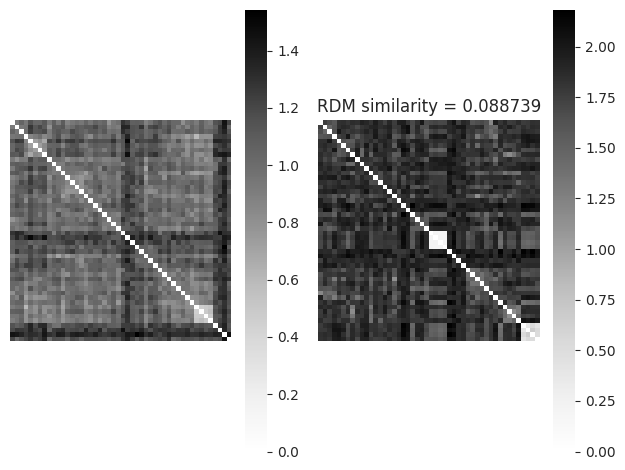

In [23]:
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(
                compact_categories, compactness, 565, listcat, models = ['saycam', 'supervised'],
                nb_considered_categories = 12, compactness_diff_measure = 'normalizedDiff'
            )
max_dissimilarity_images = find_max_dissimilarity_images(
                cat_activations, ['saycam', 'supervised'], labels[:12], 50,
                images_per_subset=4, diff = maxdiffs
            )
similarity_dict = max_rsa.compute_sub_rdm_similarity(
            max_dissimilarity_images, cat_activations, ['saycam', 'supervised'], labels[:12],
            savename = '')